

---

19CE30023, Tuhin Subhra De. Assignment 1

---



#Resnet50 Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


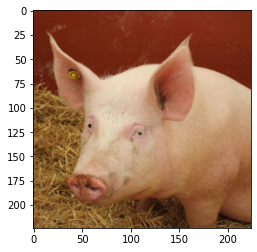

In [ ]:
from PIL import Image
from torchvision import transforms

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("/content/drive/MyDrive/Secure_dependableML/assignment1/pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

Loading Resnet model

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet50
import json
cnn = resnet50(pretrained = True)
cnn.eval();

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

##Random Noise

###Random Noise(Full Picture)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.4000) tensor(8.2850e-06)


Text(0.5, 1.0, 'Noise')

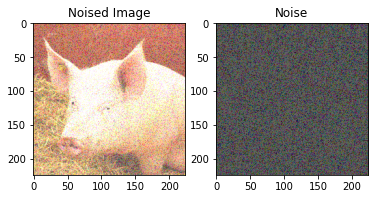

In [ ]:
#generating random noise
import torch
gen = torch.Generator()
gen.manual_seed(7)
fr_noise = torch.rand_like(pig_tensor)

epsilon = 102.

fr_noise.data.clamp_(-epsilon/255, epsilon/255)
print(torch.max(fr_noise), torch.min(fr_noise))
fr_noised_img = pig_tensor+fr_noise

fig, ax = plt.subplots(1, 2)
ax[0].imshow((fr_noised_img)[0].detach().numpy().transpose(1,2,0))
ax[0].set_title("Noised Image")
ax[1].imshow((fr_noise)[0].detach().numpy().transpose(1,2,0))
ax[1].set_title("Noise")
#plt.imshow((noised_img)[0].detach().numpy().transpose(1,2,0))

Predictions

hog
Cross Entropy Loss: 0.003882253309711814
True class probability: 0.9961252808570862 

hog
Cross Entropy Loss: 0.0059699080884456635
True class probability: 0.9940478801727295 

wombat
Cross Entropy Loss: 6.055545330047607
True class probability: 0.002344823209568858 

fire_screen
Cross Entropy Loss: 18.473119735717773
True class probability: 9.489123264927457e-09 

fire_screen
Cross Entropy Loss: 19.580615997314453
True class probability: 3.135062875969652e-09 

fire_screen
Cross Entropy Loss: 19.421375274658203
True class probability: 3.6762404231893697e-09 



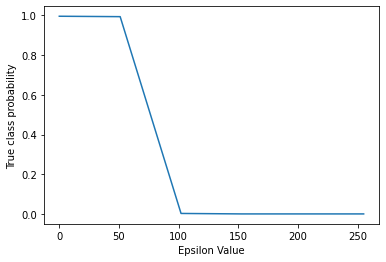

In [ ]:
noise = torch.rand_like(pig_tensor)
tcp_list = []
magnitude = [0., 51., 102., 153., 204., 255.]
for ep in magnitude:
  fr_noise = noise.clone()
  epsilon = ep
  fr_noise.data.clamp_(-epsilon/255, epsilon/255)
  fr_noised_img = pig_tensor+fr_noise
  pred = cnn(norm(fr_noised_img))

  with open("/content/drive/MyDrive/Secure_dependableML/assignment1/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    print("Cross Entropy Loss:", nn.CrossEntropyLoss()(cnn(norm(fr_noised_img)),torch.LongTensor([341])).item())
    tcp = nn.Softmax(dim=1)(pred)[0,341].item()
    print("True class probability:", tcp, '\n')
    tcp_list.append(tcp)

plt.plot(magnitude, tcp_list)
plt.xlabel("Epsilon Value")
plt.ylabel("True class probability")
plt.show()


###Random noise (half dimemsion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7843) tensor(4.1902e-05)


Text(0.5, 1.0, 'Noise')

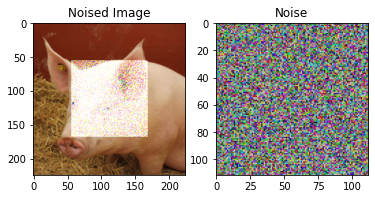

In [ ]:
#generating random noise
hr_noise = torch.rand((1, 3, 112, 112))

epsilon = 200.

hr_noise.data.clamp_(-epsilon/255, epsilon/255)
print(torch.max(hr_noise), torch.min(hr_noise))
hr_noised_img = pig_tensor.clone()
hr_noised_img[:, :, 56:168, 56:168] = hr_noised_img[:, :, 56:168, 56:168]+hr_noise

fig, ax = plt.subplots(1, 2)
ax[0].imshow((hr_noised_img)[0].detach().numpy().transpose(1,2,0))
ax[0].set_title("Noised Image")
ax[1].imshow((hr_noise)[0].detach().numpy().transpose(1,2,0))
ax[1].set_title("Noise")

hog
Cross Entropy Loss: 0.003882253309711814
True class probability: 0.9961252808570862 

hog
Cross Entropy Loss: 0.0011966219171881676
True class probability: 0.9988040924072266 

hog
Cross Entropy Loss: 0.25930798053741455
True class probability: 0.7715853452682495 

hog
Cross Entropy Loss: 0.6628900170326233
True class probability: 0.5153597593307495 

hog
Cross Entropy Loss: 0.8389003276824951
True class probability: 0.4321855306625366 

hog
Cross Entropy Loss: 1.2574193477630615
True class probability: 0.2843869924545288 



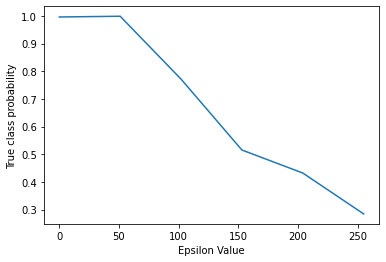

In [ ]:
noise = torch.rand((1, 3, 112, 112))
tcp_list = []
magnitude = [0., 51., 102., 153., 204., 255.]
for ep in magnitude:
  epsilon = ep
  hr_noise = noise.clone()
  hr_noise.data.clamp_(-epsilon/255, epsilon/255)
  hr_noised_img = pig_tensor.clone()
  hr_noised_img[:, :, 56:168, 56:168] = hr_noised_img[:, :, 56:168, 56:168]+hr_noise
  pred = cnn(norm(hr_noised_img))

  with open("/content/drive/MyDrive/Secure_dependableML/assignment1/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    print("Cross Entropy Loss:", nn.CrossEntropyLoss()(cnn(norm(hr_noised_img)),torch.LongTensor([341])).item())
    tcp = nn.Softmax(dim=1)(pred)[0,341].item()
    print("True class probability:", tcp, '\n')
    tcp_list.append(tcp)

plt.plot(magnitude, tcp_list)
plt.xlabel("Epsilon Value")
plt.ylabel("True class probability")
plt.show()


## Standard Random Noise 

###Standardized Noise(Full picture)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4 -0.4


Text(0.5, 1.0, 'Noise')

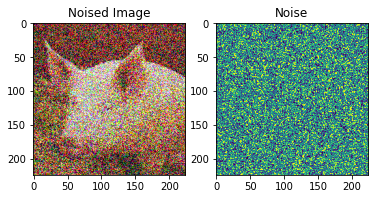

In [ ]:
#generating standardized random noise
fs_noise = np.random.normal(0, 1,(1, 3, 224, 224)) #full standard noise

epsilon = 102.

fs_noise = np.clip(fs_noise, -epsilon/255, epsilon/255)
print(np.max(fs_noise), np.min(fs_noise))
fs_noise = torch.from_numpy(fs_noise).float()
fs_noised_img = pig_tensor+fs_noise

fig, ax = plt.subplots(1, 2)
ax[0].imshow((fs_noised_img)[0].detach().numpy().transpose(1,2,0))
ax[0].set_title("Noised Image")
ax[1].imshow((fs_noise)[0][0])
ax[1].set_title("Noise")

Predictions

hog
Cross Entropy Loss: 0.003882253309711814
True class probability: 0.9961252808570862 

West_Highland_white_terrier
Cross Entropy Loss: 5.3481340408325195
True class probability: 0.004757020156830549 

honeycomb
Cross Entropy Loss: 9.836179733276367
True class probability: 5.348124977899715e-05 

bubble
Cross Entropy Loss: 13.048908233642578
True class probability: 2.152439947167295e-06 

bubble
Cross Entropy Loss: 16.26810073852539
True class probability: 8.60703934790763e-08 

bubble
Cross Entropy Loss: 18.464962005615234
True class probability: 9.566845982078576e-09 



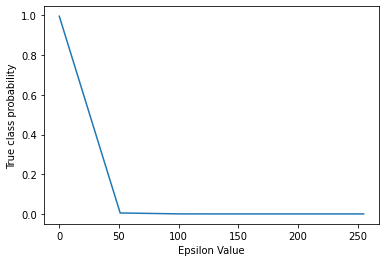

In [ ]:
noise = np.random.normal(0, 1,(1, 3, 224, 224))
noise = torch.from_numpy(noise).float()
tcp_list = []
magnitude = [0., 51., 102., 153., 204., 255.]
for ep in magnitude:
  fs_noise = noise.clone()
  epsilon = ep
  fs_noise.data.clamp_(-epsilon/255, epsilon/255)
  fs_noised_img = pig_tensor+fs_noise
  pred = cnn(norm(fs_noised_img))

  with open("/content/drive/MyDrive/Secure_dependableML/assignment1/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    print("Cross Entropy Loss:", nn.CrossEntropyLoss()(cnn(norm(fs_noised_img)),torch.LongTensor([341])).item())
    tcp = nn.Softmax(dim=1)(pred)[0,341].item()
    print("True class probability:", tcp, '\n')
    tcp_list.append(tcp)

plt.plot(magnitude, tcp_list)
plt.xlabel("Epsilon Value")
plt.ylabel("True class probability")
plt.show()

###Standard Noise(half dimensions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.4 -0.4


Text(0.5, 1.0, 'Noise')

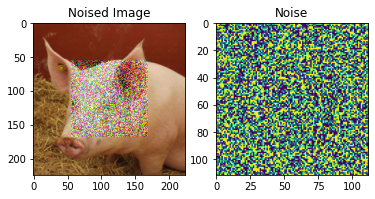

In [ ]:
hs_noise = np.random.normal(0, 1, (1, 3, 112, 112))

epsilon = 102.

hs_noise = np.clip(hs_noise, -epsilon/255, epsilon/255)
print(np.max(hs_noise), np.min(hs_noise))
hs_noise = torch.from_numpy(hs_noise).float()
hs_noised_img = pig_tensor.clone()
hs_noised_img[:, :, 56:168, 56:168] = pig_tensor[:, :, 56:168, 56:168]+hs_noise

fig, ax = plt.subplots(1, 2)
ax[0].imshow((hs_noised_img)[0].detach().numpy().transpose(1,2,0))
ax[0].set_title("Noised Image")
ax[1].imshow(hs_noise[0][0])
ax[1].set_title("Noise")

Predictions

hog
Cross Entropy Loss: 0.003882253309711814
True class probability: 0.9961252808570862 

hog
Cross Entropy Loss: 0.05933711677789688
True class probability: 0.9423890113830566 

hog
Cross Entropy Loss: 0.24246957898139954
True class probability: 0.7846876382827759 

hog
Cross Entropy Loss: 0.13080182671546936
True class probability: 0.8773916363716125 

hog
Cross Entropy Loss: 0.271146684885025
True class probability: 0.7625046372413635 

hog
Cross Entropy Loss: 0.643690824508667
True class probability: 0.5253498554229736 



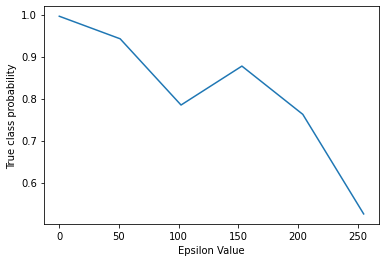

In [ ]:
noise = np.random.normal(0, 1, (1, 3, 112, 112))
noise = torch.from_numpy(noise).float()
tcp_list = []
magnitude = [0., 51., 102., 153., 204., 255.]
for ep in magnitude:
  epsilon = ep
  hs_noise = noise.clone()
  hs_noise.data.clamp_(-epsilon/255, epsilon/255)
  hs_noised_img = pig_tensor.clone()
  hs_noised_img[:, :, 56:168, 56:168] = hs_noised_img[:, :, 56:168, 56:168]+hs_noise
  pred = cnn(norm(hs_noised_img))

  with open("/content/drive/MyDrive/Secure_dependableML/assignment1/imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}
    print(imagenet_classes[pred.max(dim=1)[1].item()])
    print("Cross Entropy Loss:", nn.CrossEntropyLoss()(cnn(norm(hs_noised_img)),torch.LongTensor([341])).item())
    tcp = nn.Softmax(dim=1)(pred)[0,341].item()
    print("True class probability:", tcp, '\n')
    tcp_list.append(tcp)

plt.plot(magnitude, tcp_list)
plt.xlabel("Epsilon Value")
plt.ylabel("True class probability")
plt.show()

#Logistic Regression 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

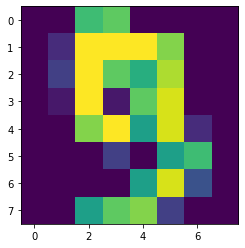

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target
plt.imshow(X[9].reshape(8,8))

In [ ]:
lr = LogisticRegression(multi_class = 'multinomial', max_iter = 1e3, C = 1, solver = 'sag')
lr.fit(X, y)
lr.score(X, y)

1.0

##Generating Random noise

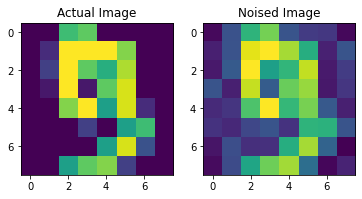

In [ ]:
np.random.seed(7)
epsilon = 7
r_noise = epsilon*np.random.rand(8, 8)
r_noise = np.clip(r_noise, 0, epsilon*0.8)
img = X[9].reshape(8, 8)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [3, 4, 5, 6, 7, 8, 9, 10]
print("Digit 9 is predicted as:")
np.random.seed(7)
for ep in epsilon_range:
  epsilon = ep;
  r_noise = epsilon*np.random.rand(8, 8)
  r_noise = np.clip(r_noise, 0, epsilon*0.8)
  noised_img = img+r_noise
  print(f"For epsilon = {epsilon}, Predicted:", lr.predict(noised_img.reshape(1, 64))[0])

Digit 9 is predicted as:
For epsilon = 3, Predicted: 9
For epsilon = 4, Predicted: 9
For epsilon = 5, Predicted: 9
For epsilon = 6, Predicted: 5
For epsilon = 7, Predicted: 5
For epsilon = 8, Predicted: 4
For epsilon = 9, Predicted: 7
For epsilon = 10, Predicted: 5


##Generating Standard Noise

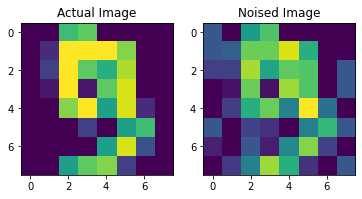

In [ ]:
np.random.seed(7)
epsilon = 7
r_noise = epsilon*np.random.normal(0, 1, (8, 8))
r_noise = np.clip(r_noise, 0, epsilon*0.8)
img = X[9].reshape(8, 8)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
print("Digit 9 is predicted as:")
np.random.seed(7)
for ep in epsilon_range:
  epsilon = ep;
  s_noise = epsilon*np.random.normal(0, 1, (8, 8))
  s_noise = np.clip(s_noise, 0, epsilon*0.8)
  noised_img = img+s_noise
  print(f"For epsilon = {epsilon}, Predicted:", lr.predict(noised_img.reshape(1, 64))[0])

Digit 9 is predicted as:
For epsilon = 2, Predicted: 9
For epsilon = 3, Predicted: 9
For epsilon = 4, Predicted: 9
For epsilon = 5, Predicted: 9
For epsilon = 6, Predicted: 5
For epsilon = 7, Predicted: 9
For epsilon = 8, Predicted: 9
For epsilon = 9, Predicted: 8
For epsilon = 10, Predicted: 5


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
import numpy as np

[0 1 2 3 4 5 6 7 8 9 0 1 2 3]


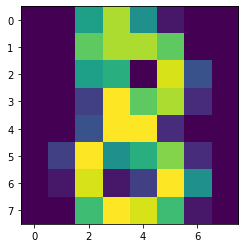

In [ ]:
digits = load_digits()
X = digits.data
y = digits.target
clf = DecisionTreeClassifier()
clf.fit(X,y)
print(clf.predict(X[:14]))
plt.imshow(X[8].reshape(8,8))

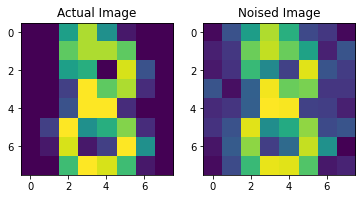

In [ ]:
np.random.seed(7)
epsilon = 7
r_noise = epsilon*np.random.rand(8, 8)
r_noise = np.clip(r_noise, 0, epsilon*0.8)
img = X[8].reshape(8, 8)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
print("Digit 8 is predicted as:")
np.random.seed(7)
for ep in epsilon_range:
 epsilon = ep;
 s_noise = epsilon*np.random.normal(0, 1, (8, 8))
 s_noise = np.clip(s_noise, 0, epsilon*0.8)
 noised_img = img+s_noise
 print(f"For epsilon = {epsilon}, Predicted:", clf.predict(noised_img.reshape(1, 64))[0])


Digit 8 is predicted as:
For epsilon = 2, Predicted: 8
For epsilon = 3, Predicted: 8
For epsilon = 4, Predicted: 8
For epsilon = 5, Predicted: 8
For epsilon = 6, Predicted: 1
For epsilon = 7, Predicted: 8
For epsilon = 8, Predicted: 8
For epsilon = 9, Predicted: 1
For epsilon = 10, Predicted: 9


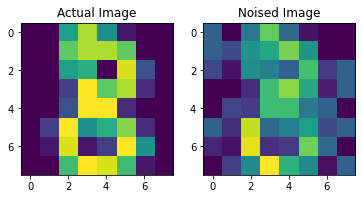

In [ ]:
np.random.seed(7)
epsilon = 9
r_noise = epsilon*np.random.normal(0, 1, (8, 8))
r_noise = np.clip(r_noise, 0, epsilon*0.8)
img = X[8].reshape(8, 8)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
print("Digit 8 is predicted as:")
np.random.seed(7)
for ep in epsilon_range:
 epsilon = ep;
 s_noise = epsilon*np.random.normal(0, 1, (8, 8))
 s_noise = np.clip(s_noise, 0, epsilon*0.8)
 noised_img = img+s_noise
 print(f"For epsilon = {epsilon}, Predicted:", clf.predict(noised_img.reshape(1, 64))[0])

Digit 8 is predicted as:
For epsilon = 2, Predicted: 8
For epsilon = 3, Predicted: 8
For epsilon = 4, Predicted: 8
For epsilon = 5, Predicted: 8
For epsilon = 6, Predicted: 1
For epsilon = 7, Predicted: 8
For epsilon = 8, Predicted: 8
For epsilon = 9, Predicted: 1
For epsilon = 10, Predicted: 9


#SVM(SVC)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import mnist
from sklearn.svm import SVC, LinearSVC

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_ms = 100
test_ms = 40
x_train = x_train[0:train_ms]
x_test = x_test[0:test_ms]
y_train = y_train[0:train_ms]
y_test = x_test[0:test_ms]

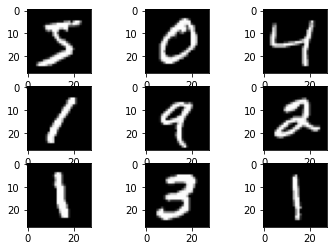

In [ ]:
from matplotlib import pyplot
for i in range(9):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [ ]:
x_train = x_train.reshape(100, 784)
x_test = x_test.reshape(40, 784)

In [ ]:
model = SVC(C=1.0, kernel='linear')
model.fit(X=x_train, y=y_train)
score = model.score(x_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 1.0000


## Generating Random Noise

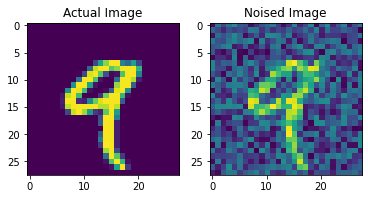

In [ ]:
np.random.seed(7)
epsilon = 240.
r_noise = epsilon*np.random.rand(28, 28)
img = x_train[4].reshape(28, 28)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [30, 60, 90, 120, 150, 180, 210, 240]
print("Digit 9 is predicted as:")
np.random.seed(7)
img = x_test[6]
for ep in epsilon_range:
  epsilon = ep;
  r_noise = epsilon*np.random.rand(28, 28)
  noised_img = img.reshape(28, 28)+r_noise
  print(f"For epsilon = {epsilon}, Predicted:", model.predict(noised_img.reshape(1, 784))[0])

Digit 9 is predicted as:
For epsilon = 30, Predicted: 9
For epsilon = 60, Predicted: 9
For epsilon = 90, Predicted: 9
For epsilon = 120, Predicted: 9
For epsilon = 150, Predicted: 9
For epsilon = 180, Predicted: 2
For epsilon = 210, Predicted: 0
For epsilon = 240, Predicted: 2


## Generating Standard Random Noise

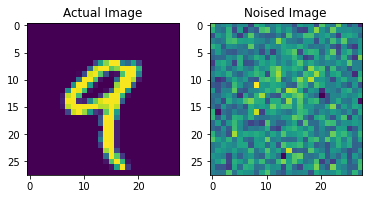

In [ ]:
np.random.seed(7)
epsilon = 240.
r_noise = epsilon*np.random.normal(0, 1, (28, 28))
img = x_train[4].reshape(28, 28)
noised_img = img+r_noise
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[0].set_title("Actual Image")
ax[1].imshow(noised_img)
ax[1].set_title("Noised Image")
plt.show()

In [ ]:
epsilon_range = [30, 60, 90, 120, 150, 180, 210, 240]
print("Digit 9 is predicted as:")
np.random.seed(7)
img = x_test[12]
for ep in epsilon_range:
  epsilon = ep;
  r_noise = epsilon*np.random.normal(0, 1, (28, 28))
  noised_img = img.reshape(28, 28)+r_noise
  print(f"For epsilon = {epsilon}, Predicted:", model.predict(noised_img.reshape(1, 784))[0])

Digit 9 is predicted as:
For epsilon = 30, Predicted: 9
For epsilon = 60, Predicted: 9
For epsilon = 90, Predicted: 9
For epsilon = 120, Predicted: 9
For epsilon = 150, Predicted: 4
For epsilon = 180, Predicted: 4
For epsilon = 210, Predicted: 9
For epsilon = 240, Predicted: 9
